In [396]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import cv2

import math
from copy import deepcopy
import array

In [397]:
### 座標から0~360度の範囲で返す 引数 pos = [x,y]
def pos2deg(pos):
    posh = [i + 0.001 for i in pos]
    deg = math.degrees(math.atan(posh[1]/posh[0]))
    if(posh[0] >= 0 and posh[1] < 0):
        deg += 360
    elif(posh[0] < 0 and posh[1] >= 0):
        deg += 180
    elif(posh[0] < 0 and posh[1] < 0):
        deg += 180
    return deg

In [398]:
### ポイント[x, y]の配列からpoint以上の数からなる直線を探す {引数} point:[[座標]], min_point:最小ポイント数
def find_line(point, min_point, tolerance):
    c_point = []
    point2 = [[i, a] for i, a in enumerate(point)]
    #print(point2)
    used_point = [[i] for i in range(len(point2))]
    line_list = []

    for i, x in enumerate(point2): #各ポイントからポイントへの角度を割り出す
        comp = deepcopy(point2)
        comp = [[j[0], j[1]] for j in comp if not(j[0] in used_point[i])] #used_pointのポイントを除外
        relative = np.array([a[1] - x[1] for a in comp])

        #相対角度の計算
        deg = np.array([[[comp[j][0], pos2deg([a[0], a[1]])] for j, a in enumerate(relative)]])
        deg = deg[0][np.argsort(deg[0][:, 1])]
        diff = np.array([abs(deg[i][1] - deg[i+1][1]) for i in range(len(deg)-1)]) #ソートした相対角度を角度の差分値でとる
        #直線であるポイントを探索
        match_count = 0 #直線上のポイント数
        line = [x[0]]
        for a, val in enumerate(diff):
            if(val <= tolerance):# tolerance度以内であれば直線と判断
                if(not(deg[a][0] in line)):
                   line.append(int(deg[a][0]))
                if(not(deg[a + 1][0] in line)):
                   line.append(int(deg[a + 1][0]))
            else:# 満たしてなければ引数条件で直線リストに格納
                if(len(line) >= min_point):
                    for b in line:
                        for c in line:
                            if(not(c in used_point[b])):
                                used_point[b].append(c)
                    line_list.append(line)
                line = [x[0]]
        if(len(line) >= min_point):# 終了時の格納
            for b in line:
                for c in line:
                    if(not(c in used_point[b])):
                        used_point[b].append(c)
            line_list.append(line)
    #推測したポイント番号を座標に変換
    line_pos_list = []
    for i in line_list:
        line_pos = []
        for j in i:
            line_pos.append(point2[j][1])
        line_pos_list.append(line_pos)

    return line_pos_list

In [399]:
### ラインの中心座標を求める
def line_COG(line_pos_list):
    lpl = deepcopy(line_pos_list)
    line_COG = []
    line_pos_COG = []
    # 各座標から重心を求める
    for i in lpl:
        x = 0
        y = 0
        for j in i:
            x += j[0]
            y += j[1]
        x = x / len(i)
        y = y / len(i)
        # 重心からの距離を求める
        distance = []
        for num, j in enumerate(i):
            distance.append([num, math.sqrt((j[0] - x)**2 + (j[1] - y)**2)])
        distance = sorted(distance, key=lambda x: x[1], reverse=True)

        pos = np.round((i[distance[0][0]] + i[distance[1][0]]) / 2)
        line_COG.append(pos.astype(np.int64))
        line_pos_COG.append([i[distance[0][0]].tolist(), i[distance[1][0]].tolist()])
        #line_COG.append([i[distance[0][0]], i[distance[1][0]]])

    return line_COG, line_pos_COG


In [400]:
### 推測した直線を描画する
def drawline(img, line_pos_list):
    for i in line_pos_list:
        for j in i:
            for k in i:
                cv2.line(img, (j[0], j[1]), (k[0], k[1]), (0, 0, 255))

In [401]:
### main ###
size = (300, 320)

img_file = "grid2.jpg"
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = cv2.resize(image, dsize=size)
outputImg = image
cv2.imwrite("output.png",image)
height, width, channels = image.shape[:3]

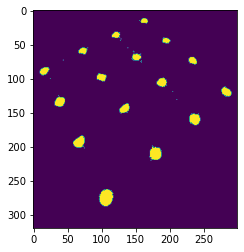

In [402]:
#image = cv2.blur(image, (3, 3))
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv_min = np.array([0,0,0])
hsv_max = np.array([255,102,255])
mask = cv2.inRange(hsv, hsv_min, hsv_max)
masked_img = cv2.bitwise_and(image, image, mask=mask)

masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

ret, img_thresh = cv2.threshold(masked_img, 1, 255, cv2.THRESH_BINARY_INV)

plt.imshow(np.asarray(img_thresh))

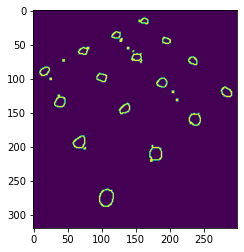

In [403]:
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = cv2.Canny(img_thresh,50,100)
kernel = np.ones((2,2),np.uint8)
image = cv2.dilate(image,kernel,iterations = 1)

cv2.imwrite("python1.png",image)

plt.imshow(np.asarray(image))

In [404]:
contours, hierarchy= cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
pointer = [i for i in range(len(contours))] #排除用
len(contours) 

23

In [405]:
# 輪郭の面積を計算する。
for i in pointer:
    cnt = contours[i]
    area = cv2.contourArea(cnt)
    #print(f"contour: {i}, area: {area}")
    if(not(50 < area and area < 500)):
        pointer[i] = -1

pointer = [i for i in pointer if i != -1] #除外された輪郭を削除



In [406]:
COG = [] #重心の配列

for i in pointer:
    try:
        cnt = contours[i]
        # 輪郭のモーメントを計算する。
        M = cv2.moments(cnt)
        # モーメントから重心を計算する。
        cx = int(round(M["m10"] / M["m00"],0))
        cy = int(round(M["m01"] / M["m00"],0))
        COG.append([cx, cy])
    except:
        pointer[i] = -1
    print(f"contour: {i}, centroid: ({cx:.2f}, {cy:.2f})")

pointer = [i for i in pointer if i != -1] #除外された輪郭を削除

contour: 0, centroid: (108.00, 275.00)
contour: 1, centroid: (180.00, 211.00)
contour: 2, centroid: (68.00, 194.00)
contour: 3, centroid: (238.00, 160.00)
contour: 4, centroid: (135.00, 145.00)
contour: 6, centroid: (39.00, 134.00)
contour: 8, centroid: (284.00, 120.00)
contour: 9, centroid: (189.00, 106.00)
contour: 11, centroid: (101.00, 99.00)
contour: 12, centroid: (17.00, 89.00)
contour: 14, centroid: (235.00, 74.00)
contour: 15, centroid: (152.00, 69.00)
contour: 18, centroid: (74.00, 59.00)
contour: 20, centroid: (196.00, 44.00)
contour: 21, centroid: (122.00, 36.00)
contour: 22, centroid: (163.00, 16.00)


In [407]:
#COG.append([122, 305])
#絞りだしたポイントから4つの重なる直線を調べる
COG = np.array(COG)
li_list = find_line(COG, 4, 1.5)
li_COG, li_pos_COG = line_COG(li_list)
a = li_pos_COG

#推測した直線の端のポイントを対象として再度ラインを見つける
point = np.array([i[0] for i in li_pos_COG] + [i[1] for i in li_pos_COG])
point = np.unique(point, axis=0)

li_list = find_line(point, 4, 1.5)
li_COG, li_pos_COG = line_COG(li_list)

#推測したラインの端のポイントから引いているラインの数を数えて、2未満のものは削除
point = np.array([i[0] for i in li_pos_COG] + [i[1] for i in li_pos_COG])
point, count = np.unique(point, return_counts=True, axis=0)
point = [a.tolist() for i,a in enumerate(point) if count[i] >= 2]

li_pos_COG2 = [i for i in li_pos_COG if i[0] in point and i[1] in point]
drawline(outputImg, li_pos_COG2)
#print(li_pos_COG)
#drawline(outputImg, COG)
#print(li_list)
#print(point)

True

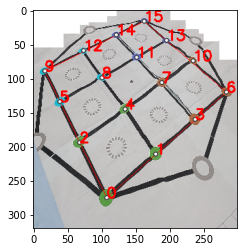

In [408]:
#推測したサークルポイントを表示させる
#draw_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
for num,i in enumerate(COG):
    #cv2.circle(outputImg, i, 3, (0, 255, 0), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    #cv2.circle(outputImg, i, 3, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA, shift=0)

    cv2.circle(outputImg, i, 3, (255, 255, 255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(outputImg, i, 3, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA, shift=0)
    cv2.putText(outputImg, str(num), i, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), thickness=2)

#表示
plt.imshow(np.asarray(outputImg), cmap="binary")
cv2.imwrite("python2.png", outputImg)

In [409]:
##推測したラインの端のポイントから引いているラインの数を数えて、ペア同士のラインを引いている合計数が4本以上である場合そのポイントを確定させる
#point = np.array([i[0] for i in li_pos_COG] + [i[1] for i in li_pos_COG])
#point, count = np.unique(point, return_counts=True, axis=0)
#print(count)
#confirm = [0 for i in range(len(point))]
#for i,a in enumerate(point):# 各ポイントごと審査する
#    li = []
#    for index, j in enumerate(li_pos_COG):# li_pos_COGから対象ポイントがある要素のみを取り出す
#        if a.tolist() in j:
#            li.append(j)
#    for j in li:# ペアの要素分繰り返し、確定したら脱却する
#        pair_line = 0
#        for k in j:# そのポイントがカウントに入っていれば加算する
#            if(k in point):
#                pair_line += count[np.where(point == k)[0][0]]
#        if(pair_line >= 4):# 合計のライン数が4以上の場合確定させる
#            confirm[i] = 1
#            break
##条件外のものは削除
#point = np.array([a.tolist() for i,a in enumerate(point) if confirm[0] == 1])
#print(point)
#
#drawline(outputImg, li_pos_COG)
##print(line_pos_COG)
##drawline(outputImg, COG)
##print(li_list)